## Importing Dependencies


In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt

import collections
import random
import numpy as np
import os
import time
import json
from PIL import Image

In [ ]:
# # Initializing tup
    
# # detect and init the TPU
# tpu = tf.distribute.cluster_resolver.TPUClusterResolver()

# # instantiate a distribution strategy
# tf.tpu.experimental.initialize_tpu_system(tpu)
# tpu_strategy = tf.distribute.TPUStrategy(tpu)

# # instantiating the model in the strategy scope creates the model on the TPU
# # with tpu_strategy.scope():
# #     model = tf.keras.Sequential( … ) # define your model normally
# #     model.compile( … )

# # train model normally
# # model.fit(training_dataset, epochs=EPOCHS, steps_per_epoch=…)

## Preparing the Dataset

For this notebook, the transformer is trained on the manually curated Dataset.

In [ ]:
import pandas as pd
BASE_PATH = '/kaggle/input/cultural-image-captioning'

In [ ]:
import csv
import collections

# Assuming annotation_file is the path to your CSV file
annotation_file =  f'{BASE_PATH}/stanford_cultural_nepali.tsv'

# Group all captions together having the same image ID.
image_path_to_caption = collections.defaultdict(list)

with open(annotation_file, 'r',newline='', encoding='utf-8') as f:
    reader = csv.DictReader(f,delimiter='\t')
    for val in reader:
        caption = f"<start> {val['Paragraph'].strip()} <end>"
        image_path = f'{BASE_PATH}/cultural_standford_image/cultural_standford_image/{val["Image_name"]}.jpg'
        image_path_to_caption[image_path].append(caption)

In [ ]:
Image.open('/kaggle/input/cultural-image-captioning/cultural_standford_image/cultural_standford_image/2388350.jpg')

In [ ]:
list(image_path_to_caption.keys())[10]

In [ ]:
image_path_to_caption['/kaggle/input/cultural-image-captioning/cultural_standford_image/cultural_standford_image/2388350.jpg']

In [ ]:
image_paths = []
with open('/kaggle/input/cultural-image-captioning/train_image.txt','r',encoding='utf-8') as f:
    lines =f.readlines()
    for line in lines:
        image_paths.append(f'{BASE_PATH}/cultural_standford_image/cultural_standford_image/{line.strip()}')
random.shuffle(image_paths)

train_image_paths = image_paths
print(len(train_image_paths))
train_image_paths[:3]

In [ ]:
test_image_paths = []
with open('/kaggle/input/cultural-image-captioning/test_image.txt','r',encoding='utf-8') as f:
    lines =f.readlines()
    for line in lines:
        test_image_paths.append(f'{BASE_PATH}/cultural_standford_image/cultural_standford_image/{line.strip()}')
random.shuffle(image_paths)

print(len(test_image_paths))
# test_image_paths[1]

In [ ]:
train_captions = []
img_name_vector = []
test_for_vocab=[]

for image_path in train_image_paths:
  caption_list = image_path_to_caption[image_path]
# caption list is the list of all the captions present in the dataset for a single image
# first caption from caption_list is extracted without annonations for vocabulary generation
  test_for_vocab.append(caption_list[0].replace("<start> ","").replace(" <end>",""))
  train_captions.extend(caption_list)
  img_name_vector.extend([image_path] * len(caption_list))

In [ ]:
# print(train_captions[:3])
# img_name_vector[:3]

In [ ]:
# test_for_vocab[:2]

## **Vocabulary Size**

In [ ]:
import nltk
# Tokenize Nepali text and calculate vocabulary size
nepali_vocab = set()
for caption in test_for_vocab:
    tokens = nltk.word_tokenize(caption)
    nepali_vocab.update(tokens)

vocabulary_size = len(nepali_vocab)
print("Vocabulary size of captions:", vocabulary_size)


**Image with longest caption**

In [ ]:
max_length = 0
max_length_image = None

for image_path, captions in image_path_to_caption.items():
    for caption in captions:
        length = len(nltk.word_tokenize(caption))
        if length > max_length:
            max_length = length
            max_length_image = image_path

print("Maximum length of captions in an image:", max_length)
print("Image with the longest caption:", max_length_image)
print(image_path_to_caption['/kaggle/input/cultural-image-captioning/cultural_standford_image/cultural_standford_image/2387207.jpg'])

In [ ]:
# Initialize variables to hold the shortest caption and its length
shortest_caption = None
shortest_caption_length = float('inf')  # Set initially to a large value

for image_name, captions in image_path_to_caption.items():
    for caption in captions:
        caption_length = len(nltk.word_tokenize(caption))
        
        # Check if the current caption is shorter than the previously found shortest
        if caption_length < shortest_caption_length:
            shortest_caption = caption
            shortest_caption_length = caption_length

print("Shortest caption:", shortest_caption)


In [ ]:
import matplotlib.pyplot as plt

# Calculate lengths of captions
caption_lengths = [len(nltk.word_tokenize(caption)) for caption in train_captions]

# Plot a histogram
plt.hist(caption_lengths, bins=30)  # Adjust bins as needed
plt.xlabel('Caption Length')
plt.ylabel('Frequency')
plt.title('Distribution of Caption Lengths')
plt.show()


In [ ]:
# Image.open('/kaggle/input/cultural-image-captioning/cultural_standford_image/cultural_standford_image/2387207.jpg')

In [ ]:
## Sanity check
# print(train_captions[11])
# Image.open(img_name_vector[11])

Currently, `train_captions` is an array of captions corresponding with each image in`image_name_vector` which is an array of image paths

The captions in the `train_captions` array are tokenized using the TensorFLow TextVectorizer with tunable hyperparameters.
Just changing the dataset into tensorflow dataset format.

In [ ]:
caption_dataset = tf.data.Dataset.from_tensor_slices(train_captions)

# We will override the default standardization of TextVectorization to preserve
# "<>" characters, so we preserve the tokens for the <start> and <end>.
def standardize(inputs):
  inputs = tf.strings.regex_replace(inputs,"।","")
  return tf.strings.regex_replace(inputs,
                                  r"!\"#$%&\(\)\*\+,-/:;=?@\[\\\]^_`{|}~", "")

# Max word count for a caption.
max_length = 100
# Use the top 10000 words for a vocabulary.
vocabulary_size =10000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    output_sequence_length=max_length)
# Learn the vocabulary from the caption data.
tokenizer.adapt(caption_dataset)

In [ ]:
vocabulary = tokenizer.get_vocabulary()

# Word index mapping
word_index = dict(zip(vocabulary, range(len(vocabulary))))
sorted_word_index = dict(sorted(word_index.items(), key=lambda x: x[1], reverse=True))
# Print vocabulary details
print("Vocabulary Size:", len(vocabulary))
print("Example Vocabulary:", vocabulary[:20])  # Print the first 20 words in the vocabulary
print("\nWord Index Mapping:")
for word, index in list(word_index.items())[:20]:  # Print the first 20 word indices
    print(f"{word}: {index}")

In [ ]:
cap_vector = caption_dataset.map(lambda x: tokenizer(x))

In [ ]:
from collections import Counter

# Sample data (replace this with your actual dataset)
captions =test_for_vocab
# Tokenize and preprocess the captions
# Perform text normalization, tokenization, and create a list of tokens
all_words = []
for caption in captions:
    tokens = caption.split()  # Replace this with your tokenizer suitable for Nepali language
    all_words.extend(tokens)

# Count occurrences of each word
word_counts = Counter(all_words)

# Vocabulary size determination (adjust as needed)
# Consider selecting the top N most frequent words or based on a threshold frequency
vocab_size = 23000  # Replace this with your chosen vocabulary size

# Get the top N most common words for vocabulary creation
most_common_words = word_counts.most_common(vocab_size - 1)  # -1 for leaving space for <UNK>

# Create a vocabulary including special tokens
vocab = ["<UNK>"] + [word for word, _ in most_common_words]
vocab_size = len(vocab)
print(len(list(set(all_words))))
print(len(most_common_words))
print(f"Chosen Vocabulary Size: {vocab_size}")
print(f"Example Vocabulary: {vocab}")


At the End, while making the predictions, we also have to detokenize the tokens into word sequences for which two layers below are initialized to create mappings for words to indices and indices to words

`index_to_word` is used to detokenize the tokens while making predictions

In [ ]:
# Create mappings for words to indices and indicies to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

As of now, the images are in the `image_name_vector` array as image paths. The model requires imagees to be fed as matrices

For this implementation, as the pretrained vision transformer model is used, the vision transformer requires images to be in the dimensions `(batch_size, IMAGE_SIZE, IMAGE_SIZE, NUM_CHANNELS)`

For the Vision transformer used:

`IMAGE_SIZE` is 224

In [ ]:
## FUnction to load the images into the required format
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.keras.layers.Resizing(224, 224)(img)
    return img

In [ ]:
image_ds = tf.data.Dataset.from_tensor_slices(img_name_vector)
image_ds = image_ds.map(
  load_image)

In [ ]:
## Sanity. check on the dataset

In [ ]:
## Normalizing the images in the dataset to be suitable for the neural network
def rescale(img):
  return img/255.

image_ds = image_ds.map(rescale)

## Initializing the pretrained Vision Transformer

In [ ]:
!pip install tensorflow_addons
!pip install --quiet vit-keras

In [ ]:
from vit_keras import vit

In [ ]:
## Image size for the Vision Transformer
IMAGE_SIZE = 224


import matplotlib.pyplot as plt
try_img = plt.imread(img_name_vector[10])
try_img = try_img/255.
plt.figure(figsize = (5, 5))
plt.imshow(try_img)
plt.axis("off")

resized_image = tf.image.resize(
    tf.convert_to_tensor([try_img]), size=(IMAGE_SIZE, IMAGE_SIZE)
)

For this implementaiton, the Vision transformer vit_b32 is used.

More details on the tensorflow hub website:

https://tfhub.dev/sayakpaul/collections/vision_transformer/1

In [ ]:
vit_model = vit.vit_b32(
        image_size = IMAGE_SIZE,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
    
        )

Instead of classification we need the vision transformer to output a tensor of shape `(batch_size, seq_len, d_model)`

So we use the second to last layer on the vision transformer as the final layer giving the output shape: `shape=(None, 50, 768)`

In [ ]:
new_input = vit_model.input
hidden_layer = vit_model.layers[-2].output
## The New Vision Transformer Model with the required output shapes
vision_transformer_model = tf.keras.Model(new_input, hidden_layer)

In [ ]:
## For experimentation, freeze the layers of the pretrained Vision transformer
for layer in vision_transformer_model.layers:
  layer.trainable = True

In [ ]:
## Checking the model summary
vision_transformer_model.summary()

### Positional Encodings for the captions

Attention layers see their input as a set of vectors, with no sequential order. This model also doesn't contain any recurrent or convolutional layers. Because of this a "positional encoding" is added to give the model some information about the relative position of the tokens in the sentence.

The positional encoding vector is added to the embedding vector. Embeddings represent a token in a d-dimensional space where tokens with similar meaning will be closer to each other. But the embeddings do not encode the relative position of tokens in a sentence. So after adding the positional encoding, tokens will be closer to each other based on the similarity of their meaning and their position in the sentence, in the d-dimensional space.

The formula for calculating the positional encoding is as follows:

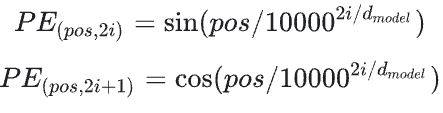

In [ ]:
def get_angles(pos, i, d_model):
  angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
  return pos * angle_rates

In [ ]:
def positional_encoding(position, d_model):
  angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

  # apply sin to even indices in the array; 2i
  angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

  # apply cos to odd indices in the array; 2i+1
  angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

  pos_encoding = angle_rads[np.newaxis, ...]

  return tf.cast(pos_encoding, dtype=tf.float32)

## Masking the sequences

The sequences are masked to seperate real tokens from paddings, the following create the masks for the tokens

In [ ]:
def create_padding_mask(seq):
  seq = tf.cast(tf.math.equal(seq, 0), tf.float32)

  # add extra dimensions to add the padding
  # to the attention logits.
  return seq[:, tf.newaxis, tf.newaxis, :]  # (batch_size, 1, 1, seq_len)

In [ ]:
def create_look_ahead_mask(size):
  mask = 1 - tf.linalg.band_part(tf.ones((size, size)), -1, 0)
  return mask  # (seq_len, seq_len)

## Scaled Dot Product Attention

Here Q, K, and V are tensors, which are the results of the matrix multiplication between trained weights Wq, Wk, and Wv. As these three matrices of weights are learned during training, the query, key, and value vectors end up being different despite of the identical input. This is why Multi-Head Attention discussed later makes sense.


In the expression for calculation of the dot product attention, Q and K are tensors. Closer Query and Key Vectors will have higher dot products. These dot products are scaled with dk which is the scaling factor for the operation referring to the dimensions of the Key tensor. Applying the softmax function will normalize the dot product to scores between 0 and 1. Finally, multiplying the softmax results with the value vectors will push the low-scoring Query and Key vectors close to zero.

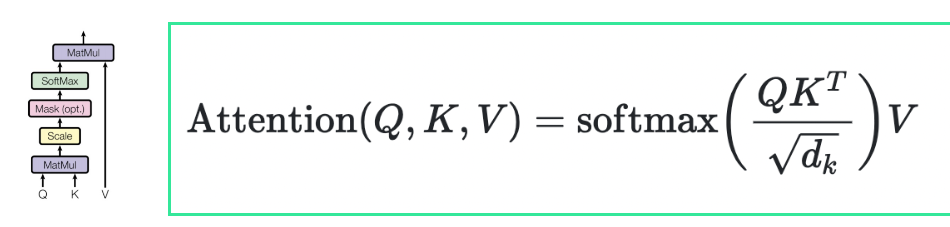

In [ ]:
def scaled_dot_product_attention(q, k, v, mask):
  """Calculate the attention weights.
  q, k, v must have matching leading dimensions.
  k, v must have matching penultimate dimension, i.e.: seq_len_k = seq_len_v.
  The mask has different shapes depending on its type(padding or look ahead)
  but it must be broadcastable for addition.

  Args:
    q: query shape == (..., seq_len_q, depth)
    k: key shape == (..., seq_len_k, depth)
    v: value shape == (..., seq_len_v, depth_v)
    mask: Float tensor with shape broadcastable
          to (..., seq_len_q, seq_len_k). Defaults to None.

  Returns:
    output, attention_weights
  """

  matmul_qk = tf.matmul(q, k, transpose_b=True)  # (..., seq_len_q, seq_len_k)

  # scale matmul_qk
  dk = tf.cast(tf.shape(k)[-1], tf.float32)
  scaled_attention_logits = matmul_qk / tf.math.sqrt(dk)

  # add the mask to the scaled tensor.
  if mask is not None:
    scaled_attention_logits += (mask * -1e9)

  # softmax is normalized on the last axis (seq_len_k) so that the scores
  # add up to 1.
  attention_weights = tf.nn.softmax(scaled_attention_logits, axis=-1)  # (..., seq_len_q, seq_len_k)

  output = tf.matmul(attention_weights, v)  # (..., seq_len_q, depth_v)

  return output, attention_weights

In [ ]:
def print_out(q, k, v):
  temp_out, temp_attn = scaled_dot_product_attention(
      q, k, v, None)
  print('Attention weights are:')
  print(temp_attn)
  print('Output is:')
  print(temp_out)

## Multi-Head Attention

In a Transformer Network, the Attention Module described earlier repeats its computations multiple times in parallel. Each of these computations is called an Attention Head. Each of these calculations is later combined to produce a final attention score.


As discussed earlier, for each Attention Head, Queries Q, Keys K, and Values V are calculated as results from learnable weight matrices Wq, Wk, and Wv. These weight matrices are different for each head, hence, for n number of heads n different weight matrices Wq, Wk and Wv are learned. Scaled dot product attention is carried out in each of the heads and finally, the results are concatenated together to form a rich representation.

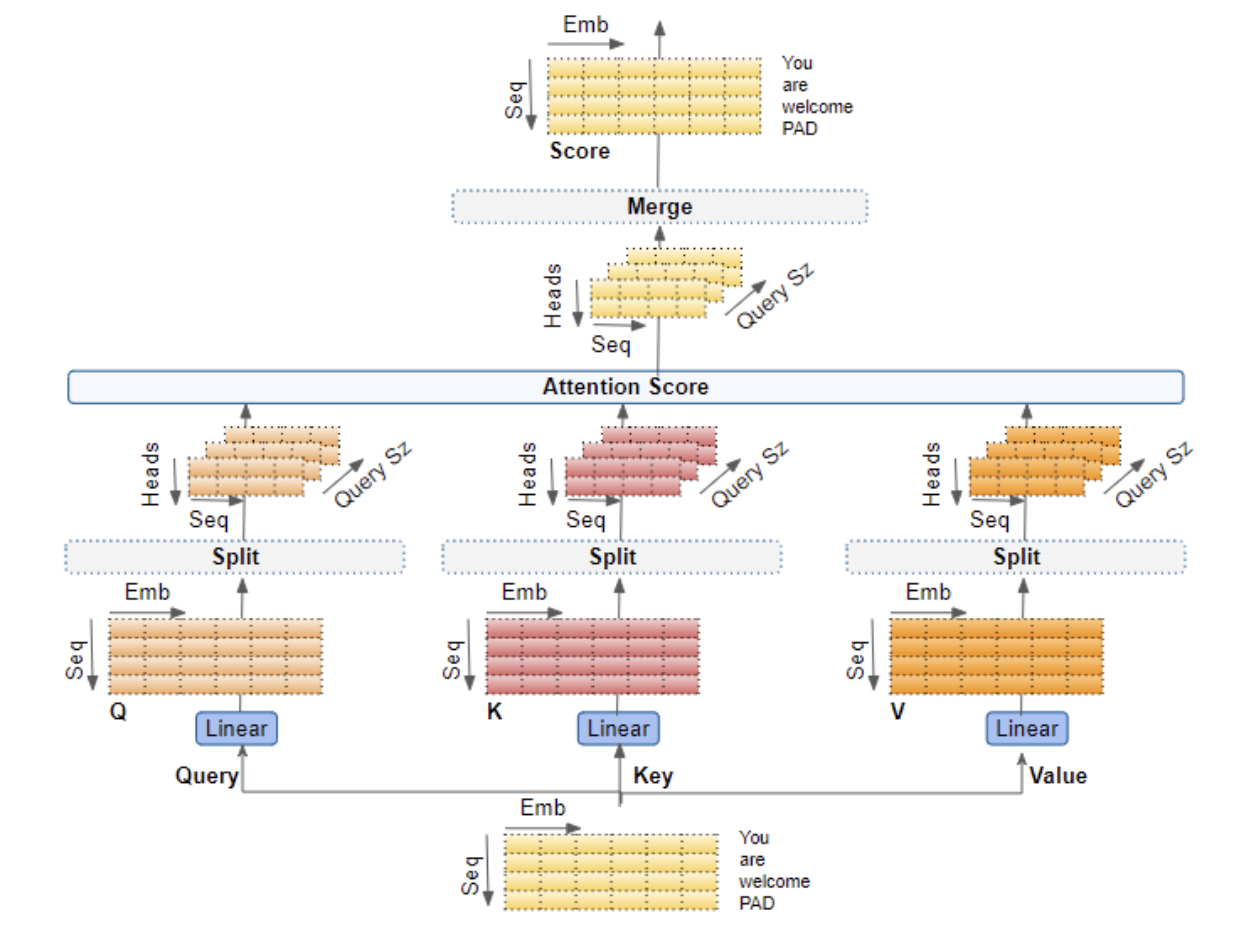

In [ ]:
class MultiHeadAttention(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads):
    super(MultiHeadAttention, self).__init__()
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.wq = tf.keras.layers.Dense(d_model)
    self.wk = tf.keras.layers.Dense(d_model)
    self.wv = tf.keras.layers.Dense(d_model)

    self.dense = tf.keras.layers.Dense(d_model)

  def split_heads(self, x, batch_size):
    """Split the last dimension into (num_heads, depth).
    Transpose the result such that the shape is (batch_size, num_heads, seq_len, depth)
    """
    x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(x, perm=[0, 2, 1, 3])

  def call(self, v, k, q, mask):
    batch_size = tf.shape(q)[0]

    q = self.wq(q)  # (batch_size, seq_len, d_model)
    k = self.wk(k)  # (batch_size, seq_len, d_model)
    v = self.wv(v)  # (batch_size, seq_len, d_model)

    q = self.split_heads(q, batch_size)  # (batch_size, num_heads, seq_len_q, depth)
    k = self.split_heads(k, batch_size)  # (batch_size, num_heads, seq_len_k, depth)
    v = self.split_heads(v, batch_size)  # (batch_size, num_heads, seq_len_v, depth)

    #print(f"Query shape: {q.shape}")
    #print(f"Key shape: {k.shape}")
    #print(f"value shape: {v.shape}")

    # scaled_attention.shape == (batch_size, num_heads, seq_len_q, depth)
    # attention_weights.shape == (batch_size, num_heads, seq_len_q, seq_len_k)
    scaled_attention, attention_weights = scaled_dot_product_attention(
        q, k, v, mask)

    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  # (batch_size, seq_len_q, num_heads, depth)

    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))  # (batch_size, seq_len_q, d_model)

    output = self.dense(concat_attention)  # (batch_size, seq_len_q, d_model)

    return output, attention_weights

## The Encoder Layer

In [ ]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, d_model, vision_transformer):
    super(Encoder, self).__init__()
    self.vit = vision_transformer
    self.units = d_model
    self.dense = tf.keras.layers.Dense(self.units, activation=tf.nn.gelu)

  def call(self, x, training, mask):
    ## x: (batch, image_size, image_size, 3)
    x = self.vit(x)
    x = self.dense(x)
    return x

In [ ]:
### Testing the Encoder
sample_encoder = Encoder(1024, vision_transformer_model)
sample_encoder_output = sample_encoder
(resized_image, training=True, mask=None)
print(sample_encoder_output.shape)  # (batch_size, input_seq_len, d_model)

## The Decoder

In [ ]:
def point_wise_feed_forward_network(d_model, dff):
  return tf.keras.Sequential([
      tf.keras.layers.Dense(dff, activation='relu'),  # (batch_size, seq_len, dff)
      tf.keras.layers.Dense(d_model)  # (batch_size, seq_len, d_model)
  ])

In [ ]:
### Decoder Layer:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self,*, d_model, num_heads, dff, rate=0.1):
    super(DecoderLayer, self).__init__()

    self.mha1 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)
    self.mha2 = MultiHeadAttention(d_model=d_model, num_heads=num_heads)

    self.ffn = point_wise_feed_forward_network(d_model, dff)

    self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
    self.layernorm3 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    self.dropout1 = tf.keras.layers.Dropout(rate)
    self.dropout2 = tf.keras.layers.Dropout(rate)
    self.dropout3 = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):
    # enc_output.shape == (batch_size, input_seq_len, d_model)

    #print(f"Decoder Layer input x shape: {x.shape}")

    attn1, attn_weights_block1 = self.mha1(x, x, x, look_ahead_mask)  # (batch_size, target_seq_len, d_model)
    attn1 = self.dropout1(attn1, training=training)
    #print("attn2 shape: ", attn1.shape)
    #print(f"x shape: {x.shape}")
    out1 = self.layernorm1(attn1 + x)

    #print(f"Encoder outpur (Value and key) shape: {enc_output.shape}")
    #print(f"out1 (Query) shape: {out1.shape}")

    attn2, attn_weights_block2 = self.mha2(
        enc_output, enc_output, out1, None)  # (batch_size, target_seq_len, d_model)
    attn2 = self.dropout2(attn2, training=training)
    out2 = self.layernorm2(attn2 + out1)  # (batch_size, target_seq_len, d_model)

    ffn_output = self.ffn(out2)  # (batch_size, target_seq_len, d_model)
    ffn_output = self.dropout3(ffn_output, training=training)
    out3 = self.layernorm3(ffn_output + out2)  # (batch_size, target_seq_len, d_model)

    return out3, attn_weights_block1, attn_weights_block2

In [ ]:
class Decoder(tf.keras.layers.Layer):
  def __init__(self,*, num_layers, d_model, num_heads, dff, target_vocab_size, max_tokens,
               rate=0.1):
    super(Decoder, self).__init__()

    self.d_model = d_model
    self.num_layers = num_layers
    self.max_tokens =  max_tokens

    self.embedding = tf.keras.layers.Embedding(target_vocab_size, d_model)
    self.pos_encoding = positional_encoding(max_tokens, d_model)

    self.dec_layers = [
        DecoderLayer(d_model=d_model, num_heads=num_heads, dff=dff, rate=rate)
        for _ in range(num_layers)]
    self.dropout = tf.keras.layers.Dropout(rate)

  def call(self, x, enc_output, training,
           look_ahead_mask, padding_mask):

    seq_len = tf.shape(x)[1]
    attention_weights = {}

    x = self.embedding(x)  # (batch_size, target_seq_len, d_model)
    x *= tf.math.sqrt(tf.cast(self.d_model, tf.float32))
    x += self.pos_encoding[:, :seq_len, :]

    x = self.dropout(x, training=training)

    for i in range(self.num_layers):
      x, block1, block2 = self.dec_layers[i](x, enc_output, training,
                                             look_ahead_mask, padding_mask)

      attention_weights[f'decoder_layer{i+1}_block1'] = block1
      attention_weights[f'decoder_layer{i+1}_block2'] = block2

    # x.shape == (batch_size, target_seq_len, d_model)
    return x, attention_weights

In [ ]:
# with tpu_strategy.scope():
sample_decoder = Decoder(num_layers=2, d_model=1024, num_heads=8,
                         dff=2048, target_vocab_size=8000, max_tokens = 60)
temp_input = tf.random.uniform((1, 60), dtype=tf.int64, minval=0, maxval=200)

output, attn = sample_decoder(temp_input,
                              enc_output=sample_encoder_output,
                              training=True,
                              look_ahead_mask=None,
                              padding_mask=None)

output.shape, attn['decoder_layer2_block2'].shape

## The Transformer

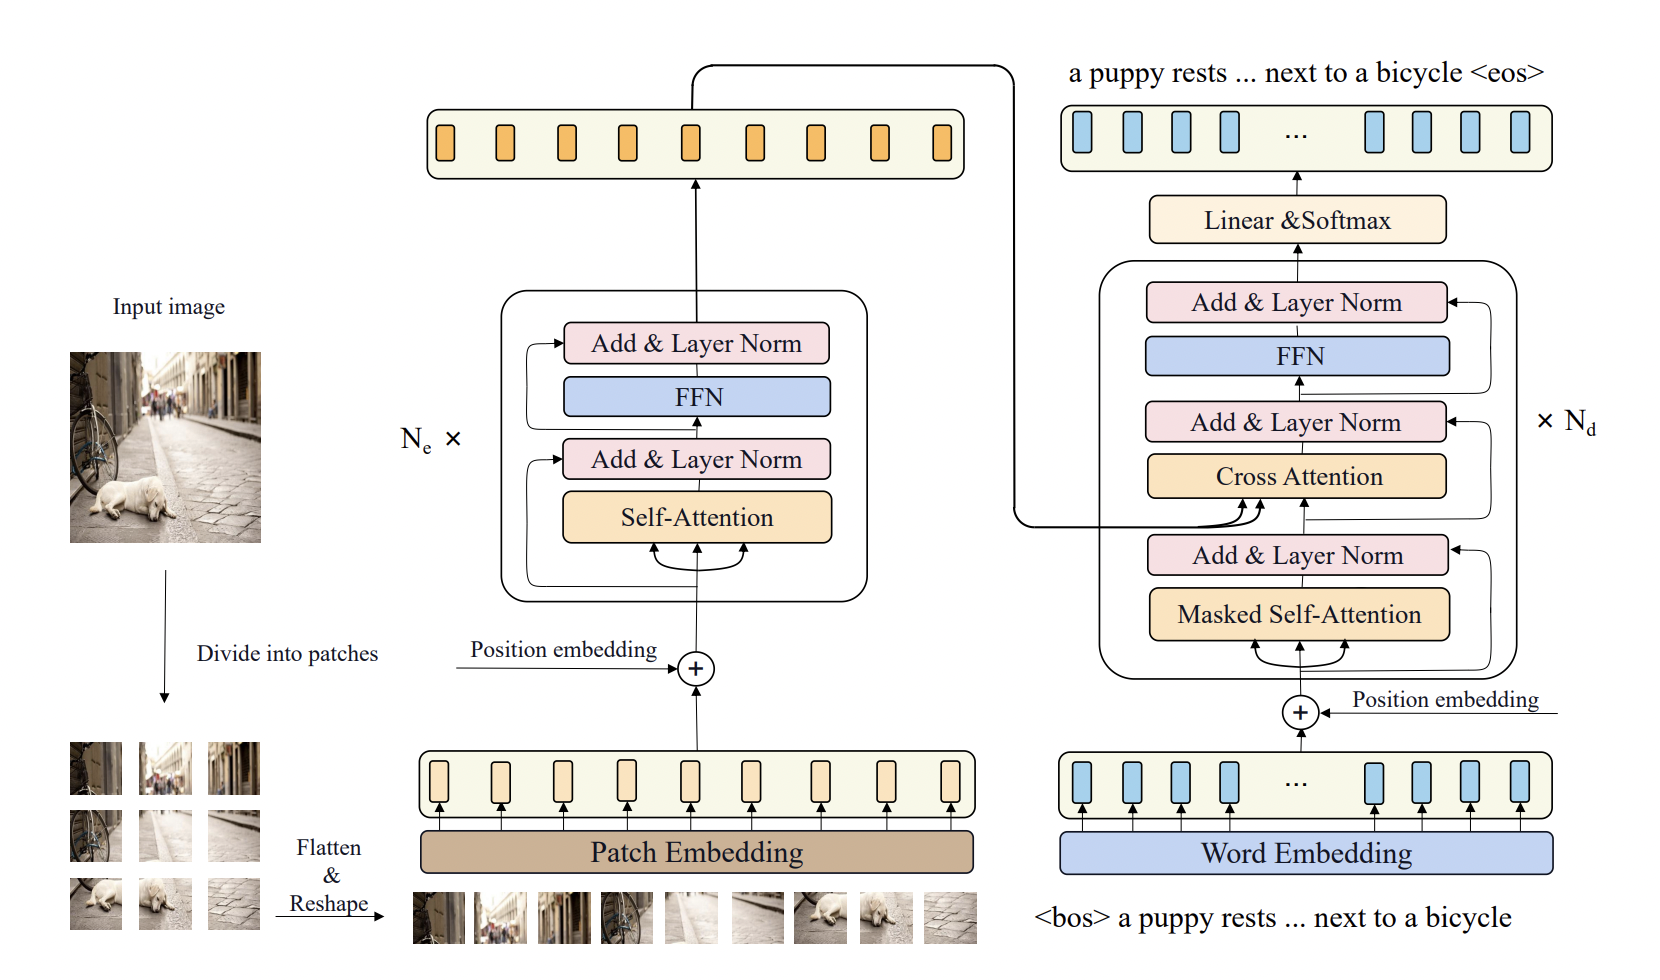

In [ ]:
class Transformer(tf.keras.Model):
  def __init__(self,*, num_layers, d_model, num_heads, dff,
               target_vocab_size, vision_transformer, max_tokens, rate=0.1):
    super().__init__()
    self.vision_transformer = vision_transformer
    self.encoder = Encoder(d_model,
                           self.vision_transformer)

    self.decoder = Decoder(num_layers=num_layers, d_model=d_model,
                           num_heads=num_heads, dff=dff,
                           target_vocab_size=target_vocab_size, max_tokens=max_tokens, rate=rate)

    self.final_layer = tf.keras.layers.Dense(target_vocab_size)

  def call(self, inputs, training):
    # Keras models prefer if you pass all your inputs in the first argument
    #print("Transformer call function called")
    inp, tar = inputs
#     print(f"inp: {inp.shape}.     tar: {tar.shape}")
    padding_mask, look_ahead_mask = self.create_masks(inp, tar)

    #print(f"Mask shapes: {padding_mask.shape}.    {look_ahead_mask.shape}")

    enc_output = self.encoder(inp, training, None)  # (batch_size, inp_seq_len, d_model)
    #print("Encoder Works")
    # dec_output.shape == (batch_size, tar_seq_len, d_model)
    dec_output, attention_weights = self.decoder(
        tar, enc_output, training, look_ahead_mask, padding_mask)

    final_output = self.final_layer(dec_output)  # (batch_size, tar_seq_len, target_vocab_size)

    return final_output, attention_weights

  def create_masks(self, inp, tar):
    # Encoder padding mask (Used in the 2nd attention block in the decoder too.)
    padding_mask = create_padding_mask(inp)

    # Used in the 1st attention block in the decoder.
    # It is used to pad and mask future tokens in the input received by
    # the decoder.
    look_ahead_mask = create_look_ahead_mask(tf.shape(tar)[1])
    dec_target_padding_mask = create_padding_mask(tar)
    look_ahead_mask = tf.maximum(dec_target_padding_mask, look_ahead_mask)

    return padding_mask, look_ahead_mask

In [ ]:
# with tpu_strategy.scope():
sample_transformer = Transformer(
    num_layers=2, d_model=512, num_heads=8, dff=2048, target_vocab_size=8000, vision_transformer = vision_transformer_model, max_tokens=60)

temp_input = tf.random.uniform((64, 38), dtype=tf.int64, minval=0, maxval=200)
temp_target = tf.random.uniform((1, 36), dtype=tf.int64, minval=0, maxval=200)

fn_out, _ = sample_transformer([resized_image, temp_target], training=True)

fn_out.shape  # (batch_size, tar_seq_len, target_vocab_size)

## Hyperparameters:

In [ ]:
## Hyperparameters for transformers
num_layers = 8
d_model = 256
dff = 512
num_heads = 4
dropout_rate = 0.1

## The Optimizer

In [ ]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    # self.d_model = d_model
    self.d_model = tf.cast(d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    step = tf.cast(step, tf.float32)  # Explicitly cast step to float32
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps ** -1.5)
    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)





In [ ]:


learning_rate = CustomSchedule(d_model)
print(learning_rate)

optimizer = tf.keras.optimizers.Adam(learning_rate, beta_1=0.9, beta_2=0.98,
                                     epsilon=1e-9)

In [ ]:
temp_learning_rate_schedule = CustomSchedule(d_model)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel('Learning Rate')
plt.xlabel('Train Step')

## Loss Metrics

In [ ]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

In [ ]:
def loss_function(real, pred):
  mask = tf.math.logical_not(tf.math.equal(real, 0))
  loss_ = loss_object(real, pred)

  mask = tf.cast(mask, dtype=loss_.dtype)
  loss_ *= mask

  return tf.reduce_sum(loss_)/tf.reduce_sum(mask)


def accuracy_function(real, pred):
  accuracies = tf.equal(real, tf.argmax(pred, axis=2))

  mask = tf.math.logical_not(tf.math.equal(real, 0))
  accuracies = tf.math.logical_and(mask, accuracies)

  accuracies = tf.cast(accuracies, dtype=tf.float32)
  mask = tf.cast(mask, dtype=tf.float32)
  return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.Mean(name='train_accuracy')

## Training the Transformer

In [ ]:
transformer = Transformer(
    num_layers=num_layers,
    d_model=d_model,
    num_heads=num_heads,
    dff=dff,
    target_vocab_size=vocabulary_size,
    vision_transformer = vision_transformer_model,
    max_tokens = 60,
    rate=dropout_rate)

In [ ]:
checkpoint_path = '/kaggle/working/model2'

ckpt = tf.train.Checkpoint(transformer=transformer,
                           optimizer=optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=10)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print('Latest checkpoint restored!!')

In [ ]:
EPOCHS = 36

The `@tf.function` is added as a decorator to speed up the training process by converting it to a graph executable:

More information on the official Tensorflow Documantation:

https://www.tensorflow.org/api_docs/python/tf/function

In [ ]:

@tf.function
def train_step(inp, tar):
    tar_inp = tar[:, :-1]
    tar_real = tar[:, 1:]

    with tf.GradientTape() as tape:
        predictions, _ = transformer([inp, tar_inp], training=True)
        loss = loss_function(tar_real, predictions)

    gradients = tape.gradient(loss, transformer.trainable_variables)
    optimizer.apply_gradients(zip(gradients, transformer.trainable_variables))

    train_loss(loss)
    train_accuracy(accuracy_function(tar_real, predictions))

## Preparing Data for training

In [ ]:
image_ds, cap_vector

In [ ]:
train_batches = tf.data.Dataset.zip((image_ds, cap_vector))

In [ ]:
train_batches

In [ ]:
BATCH_SIZE = 64

In [ ]:
train_batches = train_batches.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

In [ ]:
for (batch, (inp, tar)) in enumerate(train_batches):
  print(batch)
  print(inp.shape)
  print(tar.shape)
  break

### Training the Transformer

In [ ]:
for epoch in range(1):
  start = time.time()

  train_loss.reset_states()
  train_accuracy.reset_states()

  # inp -> portuguese, tar -> english
  for (batch, (inp, tar)) in enumerate(train_batches):
    train_step(inp, tar)

    if batch % 50 == 0:
      print(f'Epoch {epoch + 1} Batch {batch} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print(f'Saving checkpoint for epoch {epoch+1} at {ckpt_save_path}')

  print(f'Epoch {epoch + 1} Loss {train_loss.result():.4f} Accuracy {train_accuracy.result():.4f}')

  print(f'Time taken for 1 epoch: {time.time() - start:.2f} secs\n')

## Function to caption the images

In [ ]:
def caption_image(image_path, transformer):
  """
  Uses the Transformer passed in the argument to caption the image
  """
  img = plt.imread(image_path)
  resized_image = tf.image.resize(
    tf.convert_to_tensor([img]), size=(IMAGE_SIZE, IMAGE_SIZE)
  )
  ## Scaling the images
  resized_image = resized_image/255.
  ## Initializing the output arrays
  output_array = tf.TensorArray(dtype=tf.int64, size=0, dynamic_size=True)
  output_array = output_array.write(0, [1])
  output = tf.transpose(output_array.stack())


  for i in tf.range(50):
    output = tf.transpose(output_array.stack())
    predictions, _ = transformer([resized_image, output], training=False)
    predictions = predictions[:, -1:, :]
    predicted_id = tf.argmax(predictions, axis=-1)
    output_array = output_array.write(i+1, predicted_id[0])
#     if predicted_id == [4]:
#       break

  output = tf.transpose(output_array.stack())
  uncodedoutput=index_to_word(output)
  print(" ".join(byte.decode('utf-8') for byte in uncodedoutput[0].numpy()))
  plt.figure(figsize =  (5,  5))
  plt.imshow(resized_image[0])
  plt.axis("off")

In [ ]:
img_name_vector

In [ ]:

image_path='/kaggle/input/cultural-image-captioning/cultural_standford_image/cultural_standford_image/'
import random
for i in range(1):
  a = random.randint(0, 2605)
#   caption_image(test_image_paths[a], transformer)
caption_image(f'{image_path}8961156.jpg',transformer)

In [ ]:
uncodedoutput

In [ ]:
transformer.save("caption_transformer")

In [ ]:
from google.colab import files
files.download('caption_transformer')

In [ ]:
!zip /content/caption_transformer /content/

In [ ]:
# Clear output folder
import os

def remove_folder_contents(folder):
    for the_file in os.listdir(folder):
        file_path = os.path.join(folder, the_file)
        try:
            if os.path.isfile(file_path):
                os.unlink(file_path)
            elif os.path.isdir(file_path):
                remove_folder_contents(file_path)
                os.rmdir(file_path)
        except Exception as e:
            print(e)

folder_path = '/kaggle/working'
remove_folder_contents(folder_path)
os.rmdir(folder_path)



In [ ]:
import zipfile
import os

def zip_folder(folder_path, output_path):
    """
    Compresses the contents of a folder into a ZIP file.
    :param folder_path: Path to the folder to be compressed
    :param output_path: Path to save the ZIP file
    """
    with zipfile.ZipFile(output_path, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for root, dirs, files in os.walk(folder_path):
            for file in files:
                file_path = os.path.join(root, file)
                zipf.write(file_path, os.path.relpath(file_path, folder_path))

# Path to the folder you want to compress
folder_to_compress = '/kaggle/working/model2'

# Path to save the ZIP file
output_zip_path = '/kaggle/working/model2.zip'

# Compress the folder into a ZIP file
zip_folder(folder_to_compress, output_zip_path)

# Now, you can download the ZIP file using appropriate code for your environment
# For example, in a Kaggle Notebook, you might use the following to download the file
from IPython.display import FileLink
FileLink(output_zip_path)
